# Object Detection

* Download the dataset
* Format data
* Visualize with OO matplotlib
* Create classifier
* Create detector

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
torch.cuda.set_device(0)

## Format data

load in annotations

In [3]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/PASCAL_VOC'),
 PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/VOCtrainval_06-Nov-2007.tar'),
 PosixPath('data/pascal/VOCdevkit'),
 PosixPath('data/pascal/models'),
 PosixPath('data/pascal/pascal_val2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/tmp')]

In [5]:
trn_j = json.load((PATH/'pascal_train2007.json').open()) # train json
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [6]:
IMAGES, ANNOTATIONS, CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:3]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334}]

In [7]:
trn_j[ANNOTATIONS][:1]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}]

In [9]:
trn_j[CATEGORIES][:3]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'}]

In [11]:
FILE_NAME, ID, IMG_ID, CAT_ID, BBOX = ['file_name', 'id', 'image_id', 'category_id', 'bbox']

In [16]:
cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]} # id to category dictionary
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [20]:
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]} # id to filename dictionary
trn_fns[12]

'000012.jpg'

In [22]:
trn_ids = [o[ID] for o in trn_j[IMAGES]] # list of all ids for training
trn_ids[:5]

[12, 17, 23, 26, 32]

In [23]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject')]

In [24]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [26]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:3]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/007999.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005312.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/009507.jpg')]

In [27]:
im0_d = trn_j[IMAGES][0] # image number 0 dictionary
im0_d[FILE_NAME], im0_d[ID]

('000012.jpg', 12)

Convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy

In [37]:
trn_j[ANNOTATIONS][0]

{'area': 34104,
 'bbox': [155, 96, 196, 174],
 'category_id': 7,
 'id': 1,
 'ignore': 0,
 'image_id': 12,
 'iscrowd': 0,
 'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]}

In [42]:
trn_anno = collections.defaultdict(lambda:[]) # default value for keys that don't yet exist

for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = np.array([bb[1], bb[0], bb[1]+bb[3]-1, bb[0]+bb[2]-1])
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [45]:
im_a = trn_anno[im0_d[ID]]; im_a # image annotation

[(array([ 96, 155, 269, 350]), 7)]

In [46]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [47]:
cats[7]

'car'

In [48]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [49]:
cats[15], cats[13]

('person', 'horse')

Create function to convert bbox format back to VOC

In [91]:
def bb_hw(a): return np.array([a[1], a[0], a[3]-a[1]+1, a[2]-a[0]+1])

In [92]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

In [93]:
def show_img(im, figsize=None, ax=None):
    """ displays an image """
    if not ax:
        fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

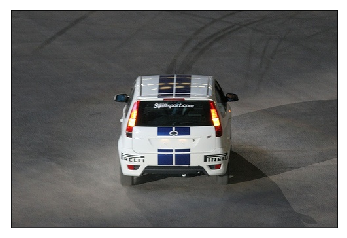

In [94]:
show_img(im)

In [95]:
def draw_outline(o, lw):
    """
    always allows text to be visible regardless of background
    
    :param o: 
    :param lw: line width
    """
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

In [96]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [97]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt, verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [98]:
b

array([ 68,   3, 323, 341])

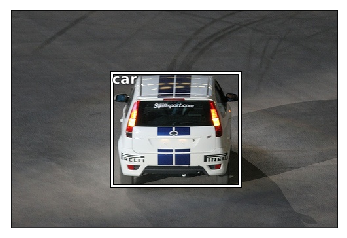

In [99]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [109]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [110]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


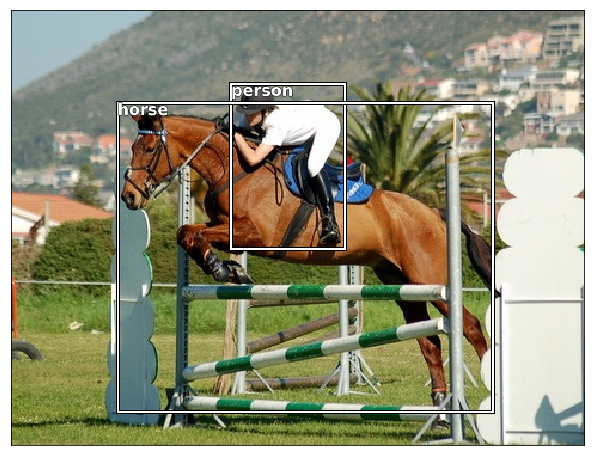

In [111]:
draw_idx(17)

## largest item classifier

In [126]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][2:]-x[0][:2]), reverse=True)
    return b[0]

In [127]:
x = trn_anno[12][0][0]; x

array([ 96, 155, 269, 350])

In [131]:
np.product(x[2:]-x[:2])

33735

In [144]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

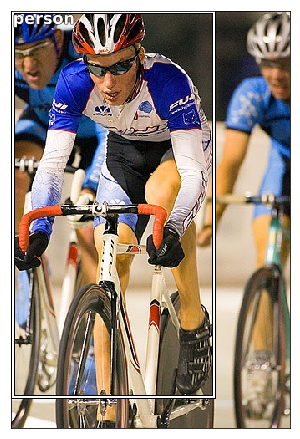

In [161]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [162]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

In [173]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)
df.head()

fn        cat
0  000012.jpg        car
1  000017.jpg      horse
2  000023.jpg     person
3  000026.jpg        car
4  000032.jpg  aeroplane

In [174]:
f_model = resnet34
sz = 224
bs = 64

In [177]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms)

In [178]:
x,y = next(iter(md.val_dl))

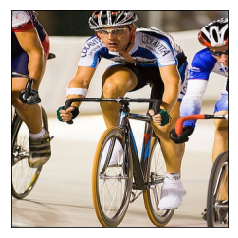

In [179]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [203]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])

In [204]:
learn.opt_fn = optim.Adam

In [205]:
lrf = learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:05<00:00,  5.05it/s, loss=10.6]


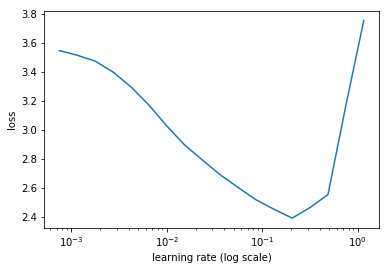

In [206]:
learn.sched.plot(n_skip_end=1)

In [207]:
lr = 2e-2

In [208]:
learn.fit(lr, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      1.206623   0.640932   0.827975  



[0.6409321, 0.827974759042263]

In [209]:
lrs = np.array([lr/1e3, lr/1e2, lr])

In [210]:
learn.freeze_to(-2)

In [212]:
learn.fit(lrs/5, 1, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy   
    0      0.573554   0.668101   0.803035  



[0.66810083, 0.8030348569154739]

In [213]:
learn.save('clas_one')

In [214]:
learn.load('clas_one')

In [215]:
x,y = next(iter(md.val_dl))

In [217]:
probs = F.softmax(predict_batch(learn.model, x), -1)

In [218]:
x,preds = to_np(x),to_np(probs)

In [219]:
preds = np.argmax(preds, -1)

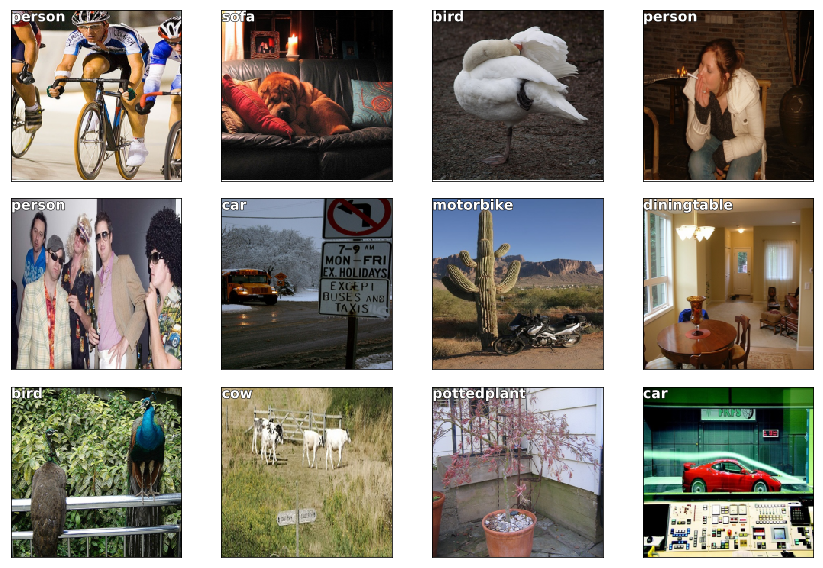

In [223]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    ima = md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

## BBOX

In [224]:
BB_CSV = PATH/'tmp/bb.csv'

In [226]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])

In [229]:
bbs = [' '.join(str(p) for p in o) for o in bb]; bbs[:5]

['96 155 269 350',
 '77 89 335 402',
 '1 2 461 242',
 '124 89 211 336',
 '77 103 182 374']

In [231]:
fns = [trn_fns[o] for o in trn_ids]; fns[:5]

['000012.jpg', '000017.jpg', '000023.jpg', '000026.jpg', '000032.jpg']

In [234]:
df = pd.DataFrame({'fn':fns, 'bbox':bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)
df.head()

fn            bbox
0  000012.jpg  96 155 269 350
1  000017.jpg   77 89 335 402
2  000023.jpg     1 2 461 242
3  000026.jpg  124 89 211 336
4  000032.jpg  77 103 182 374

In [235]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [248]:
f_model = resnet34
sz = 224
bs = 64

In [249]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [250]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 43.  25. 140. 198.]
[ 52.  38. 106. 183.]
[ 52.  38. 106. 183.]
[ 52.  38. 106. 183.]
[ 36.  22. 149. 201.]
[  7.   0. 195. 223.]
[ 66.  38. 105. 183.]
[ 52.  38. 106. 183.]
[ 64.  36. 109. 187.]


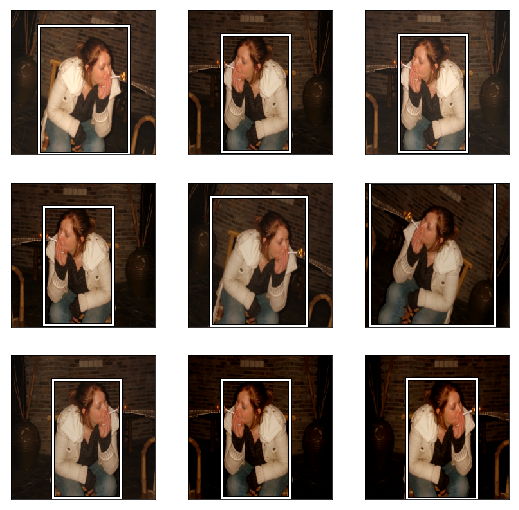

In [251]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [252]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=.5, tfm_y=tfm_y),
        RandomLighting(.05, .05)]

In [273]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True)

In [275]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1],a[2]-a[0]])

In [278]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(512*7*7,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [279]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:05<00:00,  5.07it/s, loss=465]


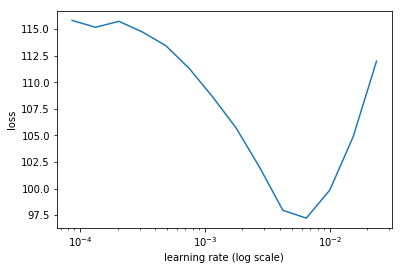

In [286]:
learn.sched.plot(n_skip=5,n_skip_end=10)

In [287]:
lr = 2e-3

In [289]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   
    0      27.964459  27.262411 
    1      26.460434  25.89986  
    2      25.537874  25.572355 



[25.572355]

In [290]:
lrs = np.array([lr/100, lr/10, lr])

In [291]:
learn.freeze_to(-2)

In [296]:
learn.fit(lrs, 2, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   
    0      21.653324  20.250744 
    1      18.494802  20.270184 
    2      16.398452  19.977255 



[19.977255]

In [297]:
bbox_save = 'bbox1'

In [297]:
learn.save(bbox_save)

In [301]:
x, y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(V(x)))

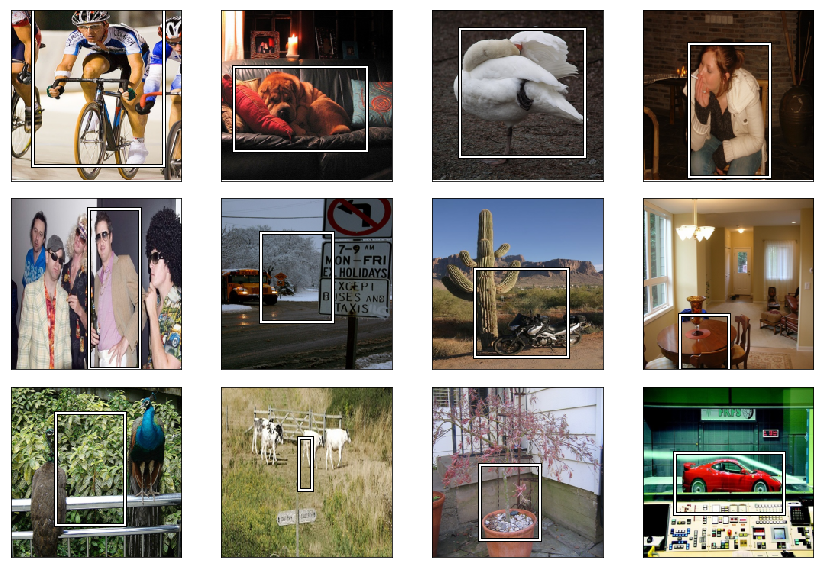

In [307]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i, ax in enumerate(axes.flat):
    im = md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(im, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection

In [308]:
f_model = resnet34
sz = 224
bs = 64

In [309]:
val_idxs = get_cv_idxs(len(trn_fns))

In [311]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, val_idxs=val_idxs)
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

In [323]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

In [324]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [327]:
val_ds2[0][1] # we have bbox and class

(array([  0.,  49., 205., 180.], dtype=float32), 14)

In [328]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

In [329]:
x,y = next(iter(md.val_dl))
idx = 3
im = md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([ 52.,  38., 106., 184.], dtype=float32)

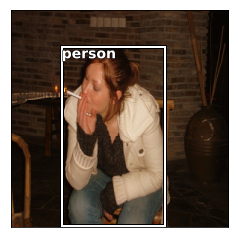

In [330]:
ax = show_img(im)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

In [335]:
hidl = 256
head_reg4 = nn.Sequential(Flatten(),
                         nn.ReLU(),
                         nn.Dropout(0.5),
                         nn.Linear(25088,hidl),
                         nn.ReLU(),
                         nn.BatchNorm1d(hidl),
                         nn.Dropout(0.5),
                         nn.Linear(hidl, 4+len(cats)))

In [336]:
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

In [337]:
learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [338]:
def detn_loss(input, target):
    bb_t, c_t = target
    bb_i, c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

In [339]:
def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i), V(bb_t)).data

In [341]:
def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

In [342]:
learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 97%|█████████▋| 31/32 [00:05<00:00,  5.76it/s, loss=648]


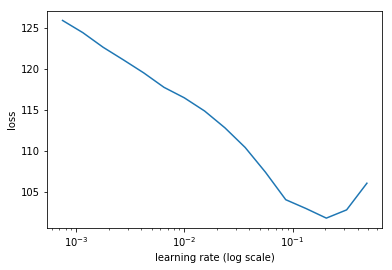

In [343]:
learn.lr_find()
learn.sched.plot()

In [344]:
lr = 2e-2

In [346]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      44.401573  41.534531  0.790415   27.455436 
    1      41.121725  36.066353  0.83098    25.315617 
    2      36.692604  34.62574   0.83143    24.022404 



[34.62574, 0.8314302861690521, 24.022403955459595]

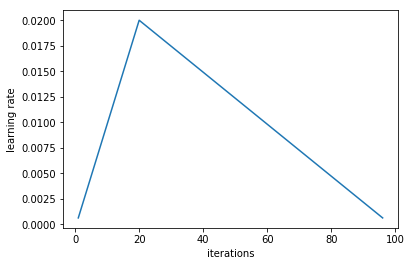

In [348]:
learn.sched.plot_lr()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 91%|█████████ | 29/32 [00:05<00:00,  5.70it/s, loss=244]


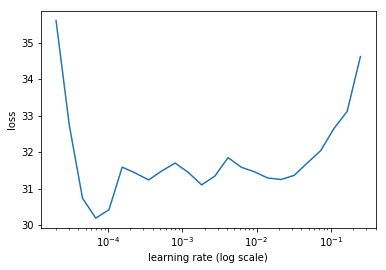

In [349]:
learn.sched

In [352]:
lrs = np.array([lr/100, lr/10, lr])

In [353]:
learn.freeze_to(-2)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 28/32 [00:09<00:01,  3.05it/s, loss=145] 


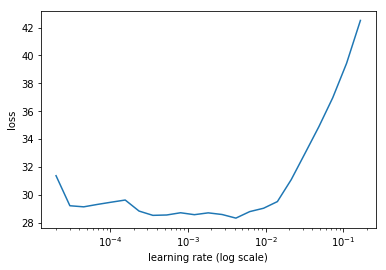

In [354]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [355]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      36.464983  47.292976  0.678786   23.73574  
    1      32.526672  37.070488  0.772987   21.494052 
    2      27.908251  34.001648  0.795974   20.075461 
    3      24.385043  31.438679  0.823768   19.262066 
    4      21.484228  31.703022  0.824669   19.211293 



[31.703022, 0.8246694728732109, 19.211292505264282]

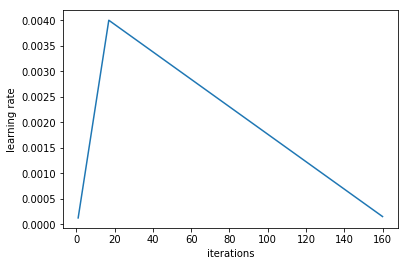

In [351]:
learn.sched.plot_lr()

In [356]:
learn.unfreeze()

In [357]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

HBox(children=(IntProgress(value=0, description='Epoch', max=10), HTML(value='')))

epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      18.645835  33.554192  0.812951   19.797445 
    1      19.148766  35.117271  0.782752   19.28794  
    2      18.420205  33.974396  0.802734   19.3818   
    3      17.69312   33.879993  0.807091   19.203455 
    4      16.604872  33.332798  0.813101   18.969241 
    5      15.555704  33.721043  0.800781   18.760708 
    6      14.414588  33.004391  0.801833   18.212145 
    7      13.691928  32.113983  0.829627   18.404258 
    8      13.018581  32.159958  0.817458   18.041784 
    9      12.521004  32.07814   0.817458   17.920837 



[32.07814, 0.8174579292535782, 17.92083716392517]

In [358]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [359]:
from scipy.special import expit

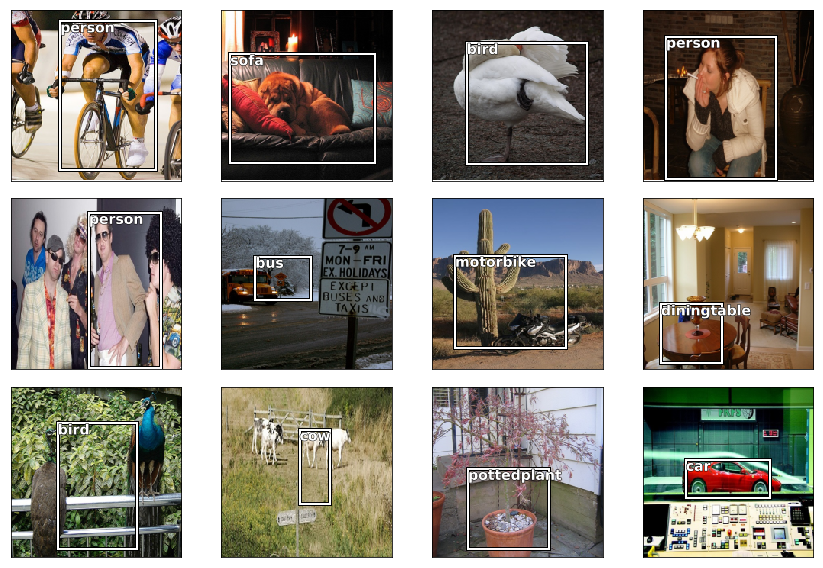

In [362]:
fig, axes = plt.subplots(3, 4, figsize=(12,8))
for i,ax in enumerate(axes.flat):
    im = md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(im, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()